In [3]:
import duckdb
import pandas as pd
from dagster import asset, Definitions, MaterializeResult, materialize
import matplotlib.pyplot as plt

### SETUP DAGSTER ENVIRONMENT

In [4]:
@asset
def my_asset():
    return "Hello from Dagster!"

In [5]:
defs = Definitions(assets=[my_asset])

### LOAD Amazon Sale Report.csv AND INSERT TO DUCKDB

In [6]:
datasource = "C:\\Users\\berna\\Documents\\Amazon Sale Report.csv"

In [7]:
db_file = "ecommerce.duckdb"

In [8]:
table_name = "amazon_sale_report"

In [9]:
@asset
def load_datasource() -> pd.DataFrame:
    """Load dataset from the provided CSV file."""
    df = pd.read_csv(datasource)
    return df

In [10]:
@asset
def insert_into_duckdb(load_datasource: pd.DataFrame):
    """Insert loaded data into a DuckDB database."""
    
    # Connect (creates DB file if not present)
    conn = duckdb.connect(db_file)
    
    # Create or replace table with CSV content
    conn.execute(f"DROP TABLE IF EXISTS {table_name}")
    conn.execute(f"CREATE TABLE {table_name} AS SELECT * FROM load_datasource")
    
    conn.close()

    return MaterializeResult(
        metadata={"rows_inserted": len(load_datasource)}
    )

In [11]:
defs = Definitions(assets=[load_datasource, insert_into_duckdb])

In [12]:
result = materialize([load_datasource, insert_into_duckdb])
result

2025-11-15 23:11:06 +0700 - dagster - DEBUG - __ephemeral_asset_job__ - 3e8893ed-ebe2-47ba-ade5-08bfc1823d9f - 15408 - RUN_START - Started execution of run for "__ephemeral_asset_job__".
2025-11-15 23:11:06 +0700 - dagster - DEBUG - __ephemeral_asset_job__ - 3e8893ed-ebe2-47ba-ade5-08bfc1823d9f - 15408 - ENGINE_EVENT - Executing steps in process (pid: 15408)
2025-11-15 23:11:06 +0700 - dagster - DEBUG - __ephemeral_asset_job__ - 3e8893ed-ebe2-47ba-ade5-08bfc1823d9f - 15408 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2025-11-15 23:11:06 +0700 - dagster - DEBUG - __ephemeral_asset_job__ - 3e8893ed-ebe2-47ba-ade5-08bfc1823d9f - 15408 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2025-11-15 23:11:06 +0700 - dagster - DEBUG - __ephemeral_asset_job__ - 3e8893ed-ebe2-47ba-ade5-08bfc1823d9f - 15408 - LOGS_CAPTURED - Started capturing logs in process (pid: 15408).
2025-11-15 23:11:06 +0700 - dagster - DEBUG - __ephemeral_asset_job_

### SHOW TABLE RESULT IN DUCKDB

In [13]:
conn = duckdb.connect(db_file)
df = conn.execute(f"SELECT * FROM {table_name} LIMIT 5").fetchdf()
conn.close()
df

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,None,False,Easy Ship,<NA>
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,<NA>
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,None,<NA>
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,None,False,Easy Ship,<NA>
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,None,False,None,<NA>


### CREATE TABLE IN DUCKDB Tracks monthly total revenue divided by product category

In [14]:
conn = duckdb.connect(db_file)
conn.execute(f"""CREATE OR REPLACE TABLE monthly_revenue_by_product_category AS
    SELECT
        strftime(date_trunc('month', strptime(Date, '%m-%d-%y')), '%Y-%m') AS month,
        Category,
        SUM(Amount) AS total_revenue
    FROM {table_name}
    GROUP BY date_trunc('month', strptime(Date, '%m-%d-%y')), Category
    ORDER BY date_trunc('month', strptime(Date, '%m-%d-%y')), Category""")


monthly_total_revenue = conn.execute("""
    SELECT * FROM monthly_revenue_by_product_category
""").fetchdf()

conn.close()

monthly_total_revenue

,month,Category,total_revenue
0,2022-03,Blouse,280.00
1,2022-03,Ethnic Dress,1099.00
2,2022-03,Set,53884.00
3,2022-03,Top,4511.00
4,2022-03,Western Dress,7653.28
5,2022-03,kurta,34256.57
6,2022-04,Blouse,195583.21
7,2022-04,Bottom,63308.45
8,2022-04,Ethnic Dress,250666.65
9,2022-04,Saree,55655.24


### CREATE TABLE IN DUCKDB Tracks the number of daily orders, divided by order status

In [15]:
conn = duckdb.connect(db_file)
conn.execute(f"""CREATE OR REPLACE TABLE daily_orders_by_status AS
    SELECT
        strptime(Date, '%m-%d-%y') AS order_date,
        Status,
        COUNT(*) AS order_count
    FROM {table_name}
    GROUP BY order_date, Status
    ORDER BY order_date, Status""")

daily_orders_by_status = conn.execute("""
    SELECT * FROM daily_orders_by_status
""").fetchdf()

conn.close()

daily_orders_by_status

,order_date,Status,order_count
0,2022-03-31,Cancelled,18
1,2022-03-31,Shipped,136
2,2022-03-31,Shipped - Delivered to Buyer,16
3,2022-03-31,Shipped - Returned to Seller,1
4,2022-04-01,Cancelled,234
...,...,...,...
452,2022-06-28,Pending - Waiting for Pick Up,252
453,2022-06-28,Shipped,665
454,2022-06-29,Cancelled,31
455,2022-06-29,Pending,454


### Generate a visual chart showing daily orders by status

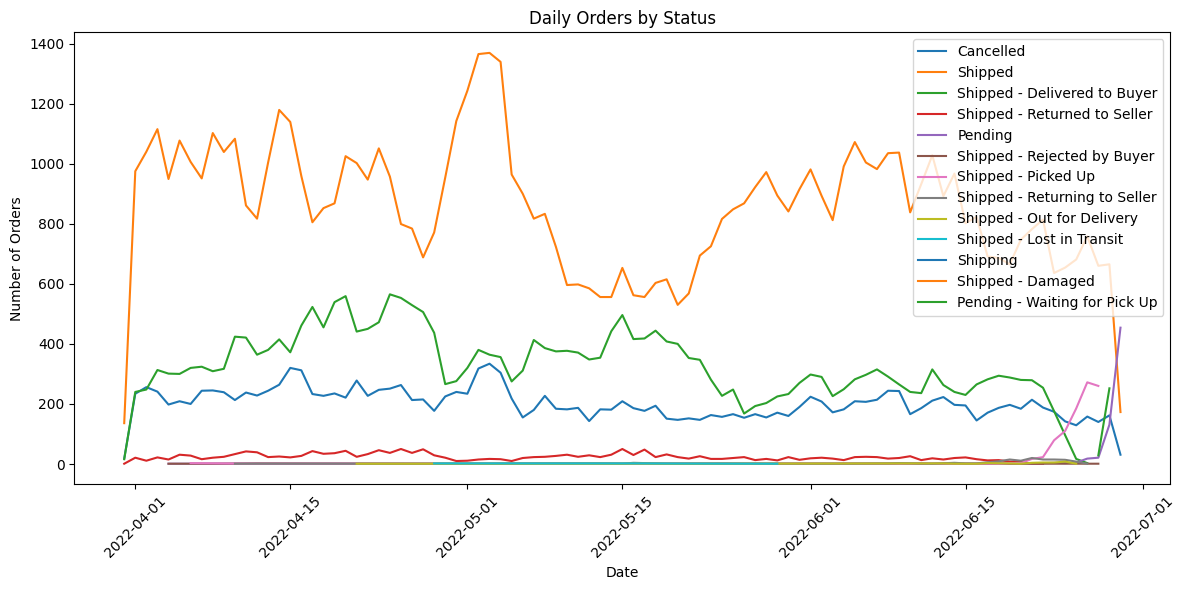

In [16]:
plt.figure(figsize=(12, 6))

for status in daily_orders_by_status['Status'].unique():
    subset = daily_orders_by_status[daily_orders_by_status['Status'] == status]
    plt.plot(subset['order_date'], subset['order_count'], label=status)

plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title("Daily Orders by Status")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Identify and display which month is the most profitable based on total revenue

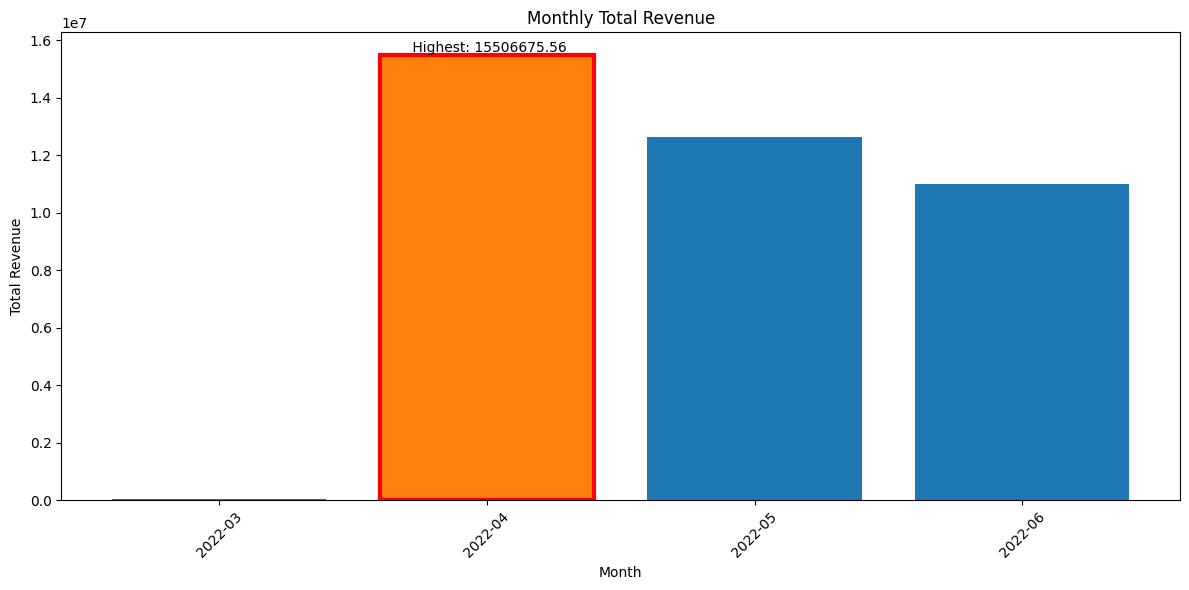

In [17]:
import matplotlib.pyplot as plt

# Sort by month if needed
monthly_total_revenue = monthly_total_revenue.sort_values("month")

# Identify most profitable month
best_month = monthly_total_revenue.loc[
    monthly_total_revenue["total_revenue"].idxmax()
]

plt.figure(figsize=(12, 6))

# Plot bar chart
plt.bar(
    monthly_total_revenue["month"],
    monthly_total_revenue["total_revenue"]
)

# Highlight the most profitable month
plt.bar(
    best_month["month"],
    best_month["total_revenue"],
    edgecolor="red",
    linewidth=3
)

plt.title("Monthly Total Revenue")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)

# Annotate best month
plt.text(
    best_month["month"],
    best_month["total_revenue"],
    f" Highest: {best_month['total_revenue']:.2f}",
    ha='center',
    va='bottom'
)

plt.tight_layout()
plt.show()
